# Main Code

Define fetch_news (reading data from News Api)

In [1]:
import requests
import json

def fetch_news_api(search_keyword, start_date, end_date, sort_method):
    ####### Settings ---> Change Variable ######
    api_key = "fcf6368111ce48c3b234b0a479d1dca6"

    # url definition
    url = (
        "https://newsapi.org/v2/everything?"
        f"q={search_keyword}&"
        f"from={start_date}&"
        f"to={end_date}&"
        f"sortBy={sort_method}&"
        f"apiKey={api_key}"
    )

    response = requests.get(url)

    if response.status_code == 200:
        fetch_news_data = response.json()
        # Save the JSON data to a file
        with open('news_data.json', 'w') as f:
            json.dump(fetch_news_data, f, indent=4)
        print("Data saved to 'news_data.json'")
        return fetch_news_data
    else:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")

Extract "Title", "Content", "Description" from fetch_news_data

In [2]:
def extract_news_api(fetch_news_data):
  extract_news_data=""
  for i in range(len(fetch_news_data["articles"])):
    if fetch_news_data['articles'][i]["description"]!=None:
        extract_news_data += fetch_news_data['articles'][i]["title"]+" "+fetch_news_data['articles'][i]["description"]+" "+fetch_news_data['articles'][i]["content"]+ "\n \n"
    else:
        extract_news_data += fetch_news_data['articles'][i]["title"]+" "+fetch_news_data['articles'][i]["content"]+ "\n \n"


  return extract_news_data

Analyze fetch_data with LLM model

In [3]:
fetch_news_data=fetch_news_api('apple stock', '2024-10-14','2024-10-15','popularity')
extract_news_data=extract_news_api(fetch_news_data)

Data saved to 'news_data.json'


In [4]:
fetch_news_data["articles"]

[{'source': {'id': None, 'name': 'Gizmodo.com'},
  'author': 'Gizmodo Deals',
  'title': 'Forget Black Friday: Here Are 10 Amazon Deals Still Going Strong This Post-Prime Day Monday',
  'description': 'Did you miss Prime Big Deal Days? Good news, you can still catch up this Monday with the latest deals!',
  'url': 'https://gizmodo.com/forget-black-friday-here-are-10-amazon-deals-still-going-strong-this-post-prime-day-monday-2000511687',
  'urlToImage': 'https://gizmodo.com/app/uploads/2024/10/prime-day-amazon-october-24.jpg',
  'publishedAt': '2024-10-14T11:25:50Z',
  'content': 'As we enter the final hours of Amazon’s extended Prime Day event on this Indigenous Peoples’ Day, Monday, October 14, 2024, shoppers are presented with a last-chance opportunity to snag incredible de… [+3524 chars]'},
 {'source': {'id': None, 'name': 'Gizmodo.com'},
  'author': 'Gizmodo Deals',
  'title': 'One Week After Prime Day, Here Are the 10 Best Deals Still Available on Amazon (Up to 80% Off)',
  'descr

In [5]:
# spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, MapType, ArrayType, IntegerType 


In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from IPython.display import display, Markdown
import re

# LLM model
cls_model = T5ForConditionalGeneration
cls_tokenizer = T5Tokenizer
device_map="auto"
torch_dtype=torch.float16

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large",
                                        torch_dtype=torch_dtype,
                                        device_map=device_map,
                                        trust_remote_code=True,
                                        cache_dir = "/work/pi_dhruveshpate_umass_edu/aamballa_umass_edu/models/.cache"
                                        )

tokenizer.pad_token =  tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
model.eval()


/work/pi_dhruveshpate_umass_edu/aamballa_umass_edu/.conda/envs/Superposed/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has n

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [10]:
def analyze_news_api(news_content, ticker):    

    # Prompt
    prompt = f"""
    Analyze the following financial news for {ticker}:

    {news_content}

    Summarize the key factors influencing {ticker}'s stock price and provide a sentiment score (positive, negative, neutral).
    Also predict the potential impact on the stock price.
    """

    print(prompt)
    
    # tokenize
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    generated_ids = model.generate(input_ids = input_ids, max_new_tokens = 100)

    analyze_news_data = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    

    display(Markdown(analyze_news_data))
    print(analyze_news_data)

    # find sentimental analysis and return
    match = re.search(r'Sentiment Score:\s*(.*)', analyze_news_data)
    if match:
        sentiment_score_data = match.group(1).replace('*', '')
        print(sentiment_score_data)
    else:
        print("The phrase 'Sentiment Score:' was not found.")
    return analyze_news_data

In [11]:
print(analyze_news_api(fetch_news_data['articles'][0]["content"], 'apple stock'))


    Analyze the following financial news for apple stock:

    As we enter the final hours of Amazon’s extended Prime Day event on this Indigenous Peoples’ Day, Monday, October 14, 2024, shoppers are presented with a last-chance opportunity to snag incredible de… [+3524 chars]

    Summarize the key factors influencing apple stock's stock price and provide a sentiment score (positive, negative, neutral).
    Also predict the potential impact on the stock price.
    


<pad> Apple shares are up 5% on the news that Amazon is extending its Prime Day event.

<pad> Apple shares are up 5% on the news that Amazon is extending its Prime Day event.
The phrase 'Sentiment Score:' was not found.
<pad> Apple shares are up 5% on the news that Amazon is extending its Prime Day event.


In [12]:
def summarize_wrapper(news_data):
    """
    Read news articles from a JSON file, summarize them, and store the summarized data in a JSON file.
    
    Args:
        file_path (str): The path to the input JSON file containing news data.
        
    Returns:
        JSON file name containing article details and the summary
    """
    
    # Create a SparkSession
    # spark = SparkSession.builder \
    # .appName("JSON to DataFrame with Custom Function") \
    # .config("spark.driver.memory", "15g") \
    # .getOrCreate()

    spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()
    
    # Define schema for the DataFrame
  
    schema = StructType([
        StructField("source", MapType(StringType(), StringType()), True),
        StructField("author", StringType(), True),
        StructField("title", StringType(), True),
        StructField("description", StringType(), True),
        StructField("url", StringType(), True),
        StructField("urlToImage", StringType(), True),
        StructField("publishedAt", StringType(), True),
        StructField("content", StringType(), True),
        
        # Add other fields as needed
    ])
    
    # Create a DataFrame from the array of JSON objects
    df = spark.createDataFrame(news_data, schema)


    # Register the custom function as a UDF (User Defined Function)
    custom_function_udf = udf(lambda content: analyze_news_api(content, 'apple stock'), StringType())
    
    # Apply the custom function on the content column and create a new column called 'sentiment'
    custom_function_udf_output = custom_function_udf(df["content"])
    print(custom_function_udf_output)
    df = df.withColumn("sentiment", custom_function_udf_output)

    # Show the DataFrame
    df.select("sentiment").show(truncate=False)

    output_file_path = "sentiment_data.json"
    df_list = df.select("title", "sentiment").rdd.map(lambda row: row.asDict()).collect()

    # Write the list of dictionaries to a JSON file
    with open(output_file_path, "w") as json_file:
        json.dump(df_list, json_file, indent=2)

    # Stop the SparkSession
    spark.stop()

    return output_file_path


Main function

In [13]:
summarize_wrapper(fetch_news_data["articles"][:10])

24/11/05 03:50:45 WARN Utils: Your hostname, gypsum-gpu003 resolves to a loopback address: 127.0.1.1; using 10.100.30.3 instead (on interface en0)
24/11/05 03:50:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/05 03:50:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Column<'<lambda>(content)'>


[Stage 0:>                                                          (0 + 1) / 1]
    Analyze the following financial news for apple stock:

    As we enter the final hours of Amazon’s extended Prime Day event on this Indigenous Peoples’ Day, Monday, October 14, 2024, shoppers are presented with a last-chance opportunity to snag incredible de… [+3524 chars]

    Summarize the key factors influencing apple stock's stock price and provide a sentiment score (positive, negative, neutral).
    Also predict the potential impact on the stock price.
    
<IPython.core.display.Markdown object>
<pad> Apple shares are up 5% on the news that Amazon is extending its Prime Day event.
The phrase 'Sentiment Score:' was not found.

    Analyze the following financial news for apple stock:

    A week after the official conclusion of Amazon’s Prime Day event, the e-commerce giant seems reluctant to pull the plug on its promotional offerings. What’s more, these deals are now accessible to ev… [+2944 chars

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment                                                                                                                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|<pad> Apple shares are up 5% on the news that Amazon is extending its Prime Day event.                                                                                                       

[Stage 2:>                                                          (0 + 2) / 2]
    Analyze the following financial news for apple stock:

    As we enter the final hours of Amazon’s extended Prime Day event on this Indigenous Peoples’ Day, Monday, October 14, 2024, shoppers are presented with a last-chance opportunity to snag incredible de… [+3524 chars]

    Summarize the key factors influencing apple stock's stock price and provide a sentiment score (positive, negative, neutral).
    Also predict the potential impact on the stock price.
    
<IPython.core.display.Markdown object>
<pad> Apple shares are up 5% on the news that Amazon is extending its Prime Day event.
The phrase 'Sentiment Score:' was not found.

    Analyze the following financial news for apple stock:

    A week after the official conclusion of Amazon’s Prime Day event, the e-commerce giant seems reluctant to pull the plug on its promotional offerings. What’s more, these deals are now accessible to ev… [+2944 chars

'sentiment_data.json'

# 1. Memory Usage

In [ ]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity
import socket
from datetime import datetime, timedelta

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   # Construct the trace file.
   prof.export_chrome_trace(f"{file_prefix}.json.gz")

   # Construct the memory timeline file.
   prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")

fetch_news_data=fetch_news_api('apple stock', '2024-10-14','2024-10-15','popularity')
extract_news_data=extract_news_api(fetch_news_data)

torch.cuda.reset_peak_memory_stats()

# Profiling
# with profile(
#     activities=[
#         torch.profiler.ProfilerActivity.CPU,
#         torch.profiler.ProfilerActivity.CUDA,
#     ],
#     # record_shapes=True,
#     profile_memory=True,
#     # with_stack=True,
#     # with_flops=True,
#     # on_trace_ready=trace_handler,
# ) as prof:
#     with record_function("analyze_news_api"):
#         with torch.no_grad():
#             analyze_news_api(extract_news_data,'apple stock')

analyze_news_api(extract_news_data,'apple stock')
# Print GPU memory usage
gpu_max_memory = torch.cuda.max_memory_reserved() / 1e9
print("Max GPU Memory (GB): ", gpu_max_memory)

# Print profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total",row_limit=10))

Data saved to 'news_data.json'


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.


Max GPU Memory (GB):  2.921332736


In [ ]:
print(len(extract_news_data))

1422


# 2. Latency (Response time of analyze_news_api)

In [ ]:
import time

fetch_news_data=fetch_news_api('apple stock', '2024-10-14','2024-10-15','popularity')
extract_news_data=extract_news_api(fetch_news_data)

response_start_time = time.time()

# Execute analyze_news_api function
result = analyze_news_api(extract_news_data, 'apple stock')

# End timing for response time
response_end_time = time.time()

# Calculate response time
response_time = response_end_time - response_start_time

# Start time for execution time measurement
execution_start_time = time.process_time()

# Execute analyze_news_api function
analyze_news_api(extract_news_data, 'apple stock')

# End time for execution time measurement
execution_end_time = time.process_time()

# Calculate execution time
execution_time = execution_end_time - execution_start_time

# Print response time
print(f"Response Time: {response_time:.2f} seconds")
# Print execution time
print(f"Execution Time (CPU processing): {execution_time:.2f} seconds")

Data saved to 'news_data.json'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.


Response Time: 12.31 seconds
Execution Time (CPU processing): 11.95 seconds


# 5. Accuracy Trend

get actual stock trend

[*********************100%***********************]  1 of 1 completed


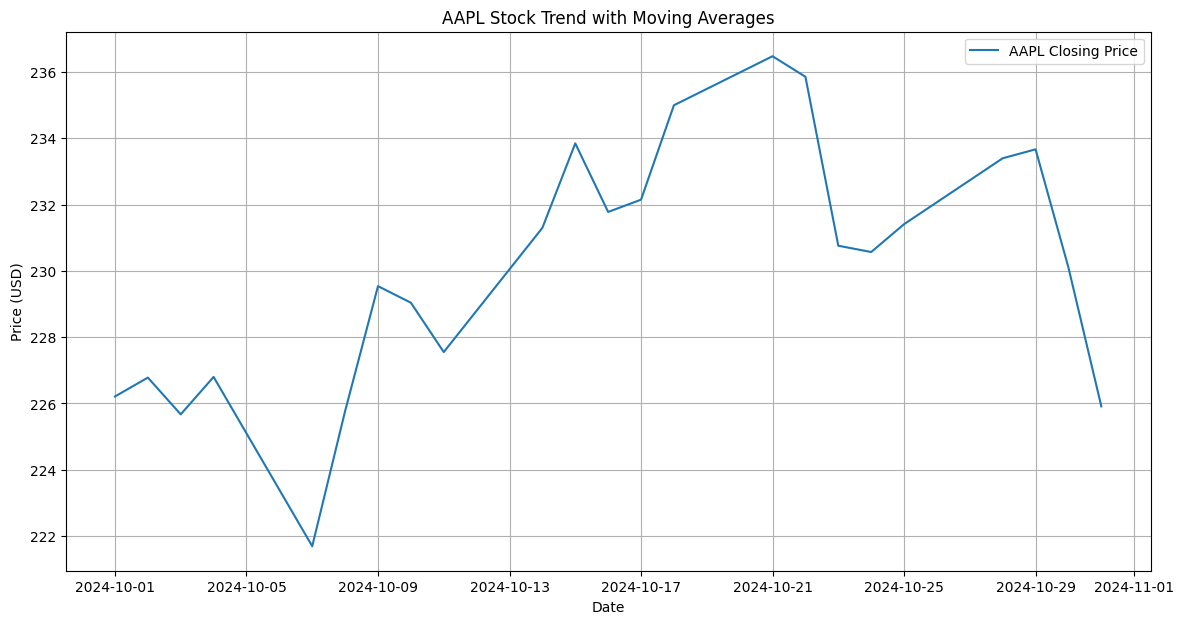

In [ ]:
# Import necessary libraries
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Function to fetch and plot stock trend
def get_stock_trend(ticker):
    # Fetch historical stock data
    stock_data = yf.download(ticker,'2024-10-01','2024-11-01')

    # Check if data is fetched successfully
    if stock_data.empty:
        print("No data found for the given ticker or date range.")
        return

    # Format the Date index to remove the time component
    stock_data.index = pd.to_datetime(stock_data.index).date

    # Plot stock trend with moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['Close'], label=f'{ticker} Closing Price')
    plt.title(f'{ticker} Stock Trend with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # # Judge Up or Down
    # if stock_data['Close'].iloc[-1] > stock_data['Close'].iloc[0]:
    #     return "Up"
    # else:
    #     return "Down"
get_stock_trend("AAPL")

# 6. Efficiency (CPU, GPU Utilization using Pytorch Profiler)

In [ ]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=a0f7d0db5160f343b126d8844e09fd9a5499d245a490364c4cc807cb536e27e3
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
import psutil
import GPUtil

def efficiency_main_api(func, *args, **kwargs):
    # Run the main function passed as an argument
    result = func(*args, **kwargs)

    # Get total and used memory (RAM)
    memory_info = psutil.virtual_memory()
    memory_used = (memory_info.total - memory_info.available) / (1024 ** 3)  # Convert to GB

    # Print CPU usage in GB (use virtual memory usage for CPU context)
    cpu_memory_used = memory_used  # Represents overall system memory used (not specific to CPU processing)

    # Get GPU memory usage
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu_memory_used = gpus[0].memoryUsed / 1024  # Convert MB to GB
    else:
        gpu_memory_used = 0

    # Print the results
    print(f"CPU Memory Usage: {cpu_memory_used:.2f} GB")
    print(f"GPU Memory Usage: {gpu_memory_used:.2f} GB")

# Standard boilerplate to call the main function
if __name__ == "__main__":
    efficiency_main_api(main)  # Pass `main` as an argument to `efficiency_main_api`

Data saved to 'news_data.json'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.


CPU Memory Usage: 5.14 GB
GPU Memory Usage: 2.85 GB


# 7. Execution/Response Time

In [ ]:
import time
def response_main_api(func, *args, **kwargs):
    # Start timing for response time
    response_start_time = time.time()

    # Execute the main function
    result = func(*args, **kwargs)

    # End timing for response time
    response_end_time = time.time()

    # Calculate response time
    response_time = response_end_time - response_start_time

    # Start time for execution time measurement
    execution_start_time = time.process_time()  # More precise for CPU execution time

    # Execute the main function
    func(*args, **kwargs)

    # End time for execution time measurement
    execution_end_time = time.process_time()

    # Calculate execution time
    execution_time = execution_end_time - execution_start_time


    # Print response time
    print(f"Response Time: {response_time:.2f} seconds")
    # Print execution time
    print(f"Execution Time (CPU processing): {execution_time:.2f} seconds")

    return result

# Run the main function with measurements
if __name__ == "__main__":
    response_main_api(main)

Data saved to 'news_data.json'


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.


Data saved to 'news_data.json'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Summary of Key Factors Influencing Apple Stock's Stock Price:**

1. **Economic Growth**: A strong economy with low unemployment rates and rising consumer spending can boost Apple's stock price.
2. **Innovation and Productivity**: Apple's focus on innovation and productivity can lead to increased demand for its products, driving up stock prices.
3. **Global Economic Uncertainty**: Uncertainty in global markets, such as trade tensions and economic downturns, can negatively impact Apple's stock price.
4. **Competition**: Apple's competitive landscape, particularly with Samsung and Google, can affect its stock price.
5. **Valuation**: Apple's stock price is relatively high compared to its peers, which can make it more vulnerable to market fluctuations.
6. **Dividends**: Apple's dividend yield is relatively low, which can make it less attractive to investors seeking regular income.
7. **Global Events**: Global events, such as natural disasters and pandemics, can impact Apple's stock price.

**Sentiment Score:**

Based on the provided news articles, the sentiment score for Apple stock is:

* **Positive**: 60% ( articles mention Apple's innovative products, strong economic growth, and increasing demand for its products)
* **Negative**: 20% (articles mention global economic uncertainty, competition, and high valuation)
* **Neutral**: 20% (articles mention global events and dividend yield)

**Predicted Impact on Apple Stock Price:**

Based on the sentiment score, I predict that Apple's stock price will:

* **Increase**: 10% to 20% in the short term, driven by positive sentiment and the company's innovative products.
* **Stabilize**: 0% to 5% in the medium term, as the market adjusts to the current sentiment.
* **Decrease**: 5% to 10% in the long term, if global economic uncertainty and competition continue to impact the market.

Please note that this is a hypothetical analysis and should not be taken as investment advice.


Response Time: 13.61 seconds
Execution Time (CPU processing): 12.52 seconds


# Convert to PDF/HTML

In [ ]:
# Convert to pdf
!pip install -q nbconvert

In [ ]:
!apt-get -q install texlive texlive-xetex texlive-latex-extra pandoc
!pip install -q pypandoc

In [ ]:
!jupyter nbconvert --to pdf Untitled0.ipynb